In [1]:
import tensorflow as tf
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
# 检查 TensorFlow 版本
print("TensorFlow version:", tf.__version__)

# 列出所有可用的物理设备
print("Physical devices:", tf.config.list_physical_devices())

# 检查是否有可用的 GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Num GPUs Available: ", len(gpus))
else:
    print("No GPU found. TensorFlow is using CPU.")

TensorFlow version: 2.6.0
Physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]
Num GPUs Available:  4


In [2]:
## import package
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, mean_squared_error
import pandas as pd

### Build up basic model


In [3]:
def create_model(input_shape, num_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Hidden Layers
    filter_sizes = [40, 20, 10, 20, 10, 30, 18, 18]
    kernel_sizes = [11, 1, 11, 1, 1, 11, 1, 3]
    x = inputs
    for filters, kernel_size in zip(filter_sizes, kernel_sizes):
        x = tf.keras.layers.Conv1D(filters, kernel_size, activation='relu', padding='same')(x)

    # Max Pooling Layer
    x = tf.keras.layers.MaxPooling1D(3)(x)

    # Flatten Layer
    x = tf.keras.layers.Flatten()(x)

    # Classification Layer
    classification_output = tf.keras.layers.Dense(input_shape[0], activation='sigmoid')(x)
    classification_output = tf.keras.layers.Reshape((input_shape[0],1))(classification_output)
    
    # Regression Layer
    reg_output = tf.keras.layers.Dense(5, name='reg_output')(x)


    # Model
    model = tf.keras.models.Model(inputs=inputs, outputs=[classification_output, reg_output])

    return model



In [4]:

input_shape = (100,1)  # 示例输入形状
num_classes = 2  # 假设有个类别

# 创建模型
model = create_model(input_shape, num_classes)
print(model.output_shape)


[(None, 100, 1), (None, 5)]


2025-01-15 10:45:51.499586: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-15 10:45:52.910514: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46350 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:16:00.0, compute capability: 8.6
2025-01-15 10:45:52.912069: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46716 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:34:00.0, compute capability: 8.6
2025-01-15 10:45:52.913604: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device

## Train the model

In [5]:
def compile_model(model):
    # 使用Adam优化器，学习率为0.002
    optimizer = optimizers.Adam(learning_rate=0.002)
    
    # 为每个输出指定一个损失函数
    losses = {
        'reshape': 'binary_crossentropy',  # 二元分类任务使用交叉熵损失函数
        'reg_output': 'mean_squared_error'  # 回归任务使用均方误差损失函数
    }
    
    # 为每个输出指定一个评估指标
    metrics = {
        'reshape': 'accuracy',  # 二元分类任务使用准确率作为评估指标
        'reg_output': tf.keras.metrics.MeanSquaredError()  # 回归任务使用均方误差作为评估指标
    }
    
    # 编译模型
    model.compile(optimizer=optimizer, loss=losses, metrics=metrics)

In [6]:
import pandas as pd
import numpy as np

def load_data(filename):
    # 读取 Excel 文件中的所有工作表名称
    xls = pd.ExcelFile(filename)
    sheet_names = xls.sheet_names

    # 初始化用于存储所有工作表数据的列表
    X_data = []
    classification_Y_data = []
    regression_Y_data = []

    # 遍历每个工作表
    for sheet_name in sheet_names:
        df = pd.read_excel(xls, sheet_name=sheet_name)
        
        # 提取 X 列和 y_classification 列的数据
        X = df['X'].to_numpy()
        Y = df['y_classification'].to_numpy()
        
        # 提取 y_regression 列的数据，作为回归任务的目标
        reg_target = df['y_regression'].dropna().to_numpy()[:5]  # 只提取前5个非 NaN 值

        # 将数据添加到列表中
        X_data.append(X)
        classification_Y_data.append(Y)
        regression_Y_data.append(reg_target)
    
    # 转换为 NumPy 数组并重塑为 (num_samples, sequence_length, num_features)
    X_data = np.array(X_data)
    classification_Y_data = np.array(classification_Y_data)
    regression_Y_data = np.array(regression_Y_data).reshape(-1, 5)

    return X_data, classification_Y_data, regression_Y_data


"""
# 示例调用
filename = "test_data.xlsx"
X_train, y_train_classification, y_train_regression = load_data(filename)

print(f'X_train shape: {X_train.shape}')
print(f'y_train_classification shape: {y_train_classification.shape}')
print(f'y_train_regression shape: {y_train_regression.shape}')
"""

'\n# 示例调用\nfilename = "test_data.xlsx"\nX_train, y_train_classification, y_train_regression = load_data(filename)\n\nprint(f\'X_train shape: {X_train.shape}\')\nprint(f\'y_train_classification shape: {y_train_classification.shape}\')\nprint(f\'y_train_regression shape: {y_train_regression.shape}\')\n'

In [7]:
from tensorflow.keras.callbacks import EarlyStopping
def train_classification_model(model, X_train, y_train_classification, y_train_regression, X_val, y_val_classification, y_val_regression):
    # 使用所有数据同时进行训练，batch_size设置为训练集大小
    batch_size = len(X_train)
    # 训练模型，训练4000个epoch

    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    history = model.fit(X_train, [y_train_classification, y_train_regression], 
                        epochs=4000, 
                        batch_size=batch_size, 
                        validation_data=(X_val, [y_val_classification, y_val_regression]),
                        callbacks=[early_stopping])
                       
                        
    return history

In [8]:
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, r2_score


def evaluate_model(model, X_val, y_val_classification, y_val_regression):
    # 预测验证集
    y_pred_classification, y_pred_regression = model.predict(X_val)
    print(f'y_pred_classification shape: {y_pred_classification.shape}')
    print(f'y_pred_regression shape: {y_pred_regression.shape}')
    
    # 将分类预测结果转换为整数标签
    y_pred_classes = (y_pred_classification > 0.5).astype(int)
    
    # 打印调试信息
    print("Debugging Information:")
    print(f'y_val_classification shape: {y_val_classification.shape}, y_val_classification dtype: {y_val_classification.dtype}')
    print(f'y_pred_classes shape: {y_pred_classes.shape}, y_pred_classes dtype: {y_pred_classes.dtype}')
    
    # 确保 y_val_classification 和 y_pred_classes 的形状一致
    y_val_classes = y_val_classification
    
    # 展开为一维数组
    y_val_classes_flat = y_val_classes.flatten()
    y_pred_classes_flat = y_pred_classes.flatten()
    
    # 打印分类报告
    print("Classification Report:")
    class_report = classification_report(y_val_classes_flat, y_pred_classes_flat, output_dict=True)
    print(classification_report(y_val_classes_flat, y_pred_classes_flat))
    
    # 将分类报告转换为 DataFrame 并写入 CSV 文件
    classification_df = pd.DataFrame(class_report).transpose()
    classification_df.to_csv('classification_report.csv', index=True)
    
    # 回归评估
    # 打印调试信息以检查形状
    print(f'y_val_regression shape: {y_val_regression.shape}')
    print(f'y_pred_regression shape: {y_pred_regression.shape}')
    
    # 确保 y_val_regression 和 y_pred_regression 的形状一致
    y_val_regression_flat = y_val_regression.flatten()
    y_pred_regression_flat = y_pred_regression.flatten()
    
    # 再次打印形状以确保一致性
    print(f'y_val_regression_flat shape: {y_val_regression_flat.shape}')
    print(f'y_pred_regression_flat shape: {y_pred_regression_flat.shape}')
    
    # 计算回归评估指标
    mse = mean_squared_error(y_val_regression_flat, y_pred_regression_flat)
    mae = mean_absolute_error(y_val_regression_flat, y_pred_regression_flat)
    r2 = r2_score(y_val_regression_flat, y_pred_regression_flat)
    
    print("Regression Evaluation:")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R^2 Score: {r2}")
    
    # 将回归评估结果写入 CSV 文件
    regression_report = {
        'Metric': ['Mean Squared Error (MSE)', 'Mean Absolute Error (MAE)', 'R^2 Score'],
        'Value': [mse, mae, r2]
    }
    regression_df = pd.DataFrame(regression_report)
    regression_df.to_csv('regression_report.csv', index=False)


"""
def get_regression_values_for_class1(model, X_val,center, y_val_regression):
    # 得到预测值
    y_pred_classification, y_pred_regression = model.predict(X_val)
    
    final_output = []
    final_validation = []

    # 将分类预测结果转换为整数标签
    y_pred_classes = (y_pred_classification > 0.5).astype(int)
    
    for i in range(len(y_pred_classes)):

        # 获取分类输出中值为1的索引
        indices = np.where(y_pred_classes[i] == 1)[0]
        
        # 对每个分类输出值为1的索引,计算它与所有中心的距离
        distances = np.abs(indices.reshape(-1, 1) - np.array(center).reshape(1, -1))

        # 找到最近的中心
        closest_center_indices = np.argmin(distances, axis=1)

        # 为每个分类输出值为1的索引返回对应的回归值
        final_output.append(y_pred_regression[i, closest_center_indices])
        final_validation.append(y_val_regression[i, closest_center_indices])

    return np.array(final_output), np.array(final_validation)
"""

def get_regression_values_for_class1(model, X_val, center, y_val_regression):
    # 得到预测值
    y_pred_classification, y_pred_regression = model.predict(X_val)
    
    final_output = []
    final_validation = []

    final_output_for_plot = []
    final_validation_for_plot = []

    class1_indices_per_sample = []  # 新增的列表来存储每个样本中被分类为 class 1 的索引

    # 将分类预测结果转换为整数标签
    y_pred_classes = (y_pred_classification > 0.5).astype(int)
    
    for i in range(len(y_pred_classes)):
        # 获取分类输出中值为1的索引
        indices = np.where(y_pred_classes[i] == 1)[0]
        
        # 记录这些索引
        class1_indices_per_sample.append(indices)

        # 对每个分类输出值为1的索引，计算它与所有中心的距离
        distances = np.abs(indices.reshape(-1, 1) - np.array(center).reshape(1, -1))

        # 找到最近的中心
        closest_center_indices = np.argmin(distances, axis=1)

        # 为每个分类输出值为1的索引返回对应的回归值
        final_output.extend(y_pred_regression[i][closest_center_indices].tolist())
        final_validation.extend(y_val_regression[i][closest_center_indices].tolist())

        # 为plot存数据
        final_output_for_plot.append(y_pred_regression[i, closest_center_indices])
        final_validation_for_plot.append(y_val_regression[i, closest_center_indices])

    return np.array(final_output), np.array(final_validation), np.array(final_output_for_plot, dtype=object), np.array(final_validation_for_plot, dtype=object), class1_indices_per_sample

In [9]:
Training_areas = [[0,1,5,50,95,100],[0,1,5,50,95,100,200],[0,1,5,50,95,200,300],[0,1,5,50,95,300,400],[0,1,5,50,95,400,500],[0,1,5,50,95,500,600],[0,1,5,50,95,600,700],[0,1,5,50,95,700,800],[0,1,5,50,95,800,900],[0,1,5,50,95,900,1000]]
Training_areas_new = []

# 更改训练数据的分位数区间
for areas in Training_areas:
    max_area = areas[-1]  # 获取当前区间的最大值
    # 创建新的四分位数区间，并四舍五入到最接近的整数
    new_areas = [round(val) for val in [0, 0.2*max_area, 0.5*max_area, 0.8*max_area, max_area]]
    Training_areas_new.append(new_areas)

print(Training_areas_new)

[[0, 20, 50, 80, 100], [0, 40, 100, 160, 200], [0, 60, 150, 240, 300], [0, 80, 200, 320, 400], [0, 100, 250, 400, 500], [0, 120, 300, 480, 600], [0, 140, 350, 560, 700], [0, 160, 400, 640, 800], [0, 180, 450, 720, 900], [0, 200, 500, 800, 1000]]


In [10]:
from tensorflow.keras import backend as K
import Generate_comparision


centers = [20,30,40,60,70]
sigma = 8
noise_level = 1/300 
Training_areas =[[0,1,2,4,20, 50, 80, 100], [0,1,4,6,40, 100, 160, 200], [0,1,6,8,60,150,240,300], [0, 1,8,10,80, 200, 320, 400], [0, 1,10,12,100, 250, 400, 500], [0, 1,12,14,120, 300, 480, 600], [0,1,14,16,140, 350, 560, 700], [0,1,16,18,160, 400, 640, 800], [0,1,18,20,180, 450, 720, 900], [0,1,20,22,200, 500, 800, 1000]]
#Testing_areas = [[0,2,30,60,100] ,[0,2,70,120,175],[0,2,80,170,280],[0,2,100,250,370],[0,2,160,300,480],[0,2,240,350,560],[0,2,255,400,600],[0,2,290,450,720],[0,2,340,500,800],[0,2,370,550,880]]
Testing_areas = [
    [0, 2, 25, 55, 105],
    [0, 3, 45, 110, 180],
    [0, 4, 75, 160, 275],
    [0, 5, 95, 260, 385],
    [0, 6, 150, 310, 490],
    [0, 7, 230, 360, 590],
    [0, 8, 250, 410, 610],
    [0, 9, 280, 460, 730],
    [0, 10, 330, 510, 810],
    [0, 12, 360, 550, 900]
]


absolute_list = []
relative_list = []

for i in range(len(Training_areas)):
    K.clear_session()
    strategy = tf.distribute.MirroredStrategy()

    with strategy.scope():
    # 设置输入形状和类别数量
        input_shape = (100,1)  # 示例输入形状
        num_classes = 2  # 假设有2个类别

        # 创建模型
        model = create_model(input_shape, num_classes)
        model.summary()

        # 编译模型
        compile_model(model)

    # 加载和预处理数据
    # 从 train_data.xlsx 中加载数据
    X_train, y_train_classification, y_train_regression = Generate_comparision.generate_data(centers, Training_areas[i], sigma, noise_level, x_size=100)
    # 划分训练集和验证集
    X_train, X_val, y_train_classification, y_val_classification, y_train_regression, y_val_regression = train_test_split(X_train, y_train_classification, y_train_regression, test_size=0.2)


    # 从 test_data.xlsx 中加载数据（如果有相同的结构）
    X_test, y_test_classification, y_test_regression = Generate_comparision.generate_data(centers, Testing_areas[i], sigma, noise_level, x_size=100)

    # 训练模型
    history = train_classification_model(model, X_train, y_train_classification, y_train_regression, X_val, y_val_classification, y_val_regression)

    # 评估模型
    evaluate_model(model, X_test, y_test_classification, y_test_regression)

    #得到最终的回归值
    centers = [20,30,40,60,70]
    final,val,pred_plot,test_plot,indices_for_class1  = get_regression_values_for_class1(model, X_test,centers,y_test_regression)

    y_pred_classification, y_pred_regression = model.predict(X_test)
    y_pred_classes = (y_pred_classification > 0.5).astype(int)
    y_val_classes_flat = y_test_classification.flatten()
    y_pred_classes_flat = y_pred_classes.flatten() 
    y_pred_regression_flat = y_pred_regression.flatten()
    y_val_regression_flat = y_test_regression.flatten()

    container_all = []
    container_relative = []
    for i in range (len(y_pred_regression_flat)):
        error = y_pred_regression_flat[i] -  y_val_regression_flat[i]
        container_all.append(error)
        if y_val_regression_flat[i] == 0:
            relative_error = error/1
        else:
            relative_error = error/y_val_regression_flat[i]
        container_relative.append(relative_error)
    
    absolute_list.append(container_all)
    relative_list.append(container_relative)





X_data shape: (1296, 100)
y_classification shape: (1296, 100)
y_regression shape: (1296, 4)
y_regression [0 0 0 0]
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 100, 40)      480         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)              

2025-01-15 10:45:57.715252: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_1156"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 26214
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Au

Epoch 1/4000
INFO:tensorflow:batch_all_reduce: 20 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 20 all-reduces with algorithm = nccl, num_packs = 1


2025-01-15 10:46:02.837740: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2025-01-15 10:46:03.691801: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2025-01-15 10:46:04.345286: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2025-01-15 10:46:05.228170: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2025-01-15 10:46:06.804531: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - ETA: 0s - loss: 2411.1660 - reshape_loss: 0.6943 - reg_output_loss: 2410.4719 - reshape_accuracy: 0.4412 - reg_output_mean_squared_error: 2410.4719

2025-01-15 10:46:07.691355: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_8872"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = AutoS

1/1 [==============================] - 12s 12s/step - loss: 2411.1660 - reshape_loss: 0.6943 - reg_output_loss: 2410.4719 - reshape_accuracy: 0.4412 - reg_output_mean_squared_error: 2410.4719 - val_loss: 2434.3118 - val_reshape_loss: 0.6884 - val_reg_output_loss: 2433.6235 - val_reshape_accuracy: 0.7092 - val_reg_output_mean_squared_error: 2433.6235
Epoch 2/4000
1/1 [==============================] - 0s 159ms/step - loss: 2409.6396 - reshape_loss: 0.6884 - reg_output_loss: 2408.9512 - reshape_accuracy: 0.7089 - reg_output_mean_squared_error: 2408.9512 - val_loss: 2432.0105 - val_reshape_loss: 0.6795 - val_reg_output_loss: 2431.3311 - val_reshape_accuracy: 0.8349 - val_reg_output_mean_squared_error: 2431.3311
Epoch 3/4000
1/1 [==============================] - 0s 157ms/step - loss: 2407.3694 - reshape_loss: 0.6796 - reg_output_loss: 2406.6899 - reshape_accuracy: 0.8347 - reg_output_mean_squared_error: 2406.6899 - val_loss: 2428.1499 - val_reshape_loss: 0.6628 - val_reg_output_loss: 2427

2025-01-15 10:47:56.625222: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_322273"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Aut

y_pred_classification shape: (3125, 100, 1)
y_pred_regression shape: (3125, 5)
Debugging Information:
y_val_classification shape: (3125, 100), y_val_classification dtype: float64
y_pred_classes shape: (3125, 100, 1), y_pred_classes dtype: int64
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    300000
         1.0       1.00      1.00      1.00     12500

    accuracy                           1.00    312500
   macro avg       1.00      1.00      1.00    312500
weighted avg       1.00      1.00      1.00    312500

y_val_regression shape: (3125, 5)
y_pred_regression shape: (3125, 5)
y_val_regression_flat shape: (15625,)
y_pred_regression_flat shape: (15625,)
Regression Evaluation:
Mean Squared Error (MSE): 0.01525525747780267
Mean Absolute Error (MAE): 0.09338677198803425
R^2 Score: 0.999990074911858


2025-01-15 10:47:59.130993: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_323398"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Aut

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 100, 40)      480         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 100, 20)      820         conv1d[0][0]                     
_______________________________________________

2025-01-15 10:48:02.733606: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_325146"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 26214
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = 

Epoch 1/4000
INFO:tensorflow:batch_all_reduce: 20 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 20 all-reduces with algorithm = nccl, num_packs = 1
1/1 [==============================] - ETA: 0s - loss: 9640.1377 - reshape_loss: 0.6936 - reg_output_loss: 9639.4443 - reshape_accuracy: 0.5069 - reg_output_mean_squared_error: 9639.4443

2025-01-15 10:48:06.896449: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_332862"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Aut

1/1 [==============================] - 6s 6s/step - loss: 9640.1377 - reshape_loss: 0.6936 - reg_output_loss: 9639.4443 - reshape_accuracy: 0.5069 - reg_output_mean_squared_error: 9639.4443 - val_loss: 9636.5703 - val_reshape_loss: 0.6544 - val_reg_output_loss: 9635.9160 - val_reshape_accuracy: 0.6386 - val_reg_output_mean_squared_error: 9635.9160
Epoch 2/4000
1/1 [==============================] - 0s 158ms/step - loss: 9600.4639 - reshape_loss: 0.6546 - reg_output_loss: 9599.8096 - reshape_accuracy: 0.6388 - reg_output_mean_squared_error: 9599.8096 - val_loss: 9565.5586 - val_reshape_loss: 0.5730 - val_reg_output_loss: 9564.9854 - val_reshape_accuracy: 0.7589 - val_reg_output_mean_squared_error: 9564.9854
Epoch 3/4000
1/1 [==============================] - 0s 144ms/step - loss: 9529.6533 - reshape_loss: 0.5734 - reg_output_loss: 9529.0811 - reshape_accuracy: 0.7585 - reg_output_mean_squared_error: 9529.0801 - val_loss: 9440.1309 - val_reshape_loss: 0.4431 - val_reg_output_loss: 9439.6

2025-01-15 10:51:36.662606: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_933771"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Aut

y_pred_classification shape: (3125, 100, 1)
y_pred_regression shape: (3125, 5)
Debugging Information:
y_val_classification shape: (3125, 100), y_val_classification dtype: float64
y_pred_classes shape: (3125, 100, 1), y_pred_classes dtype: int64
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    300000
         1.0       1.00      1.00      1.00     12500

    accuracy                           1.00    312500
   macro avg       1.00      1.00      1.00    312500
weighted avg       1.00      1.00      1.00    312500

y_val_regression shape: (3125, 5)
y_pred_regression shape: (3125, 5)
y_val_regression_flat shape: (15625,)
y_pred_regression_flat shape: (15625,)
Regression Evaluation:
Mean Squared Error (MSE): 0.026863815364994357
Mean Absolute Error (MAE): 0.11991711684304476
R^2 Score: 0.9999943289870119


2025-01-15 10:51:38.955104: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_934896"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Aut

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 100, 40)      480         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 100, 20)      820         conv1d[0][0]                     
_______________________________________________

2025-01-15 10:51:42.378539: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_936644"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 26214
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = 

Epoch 1/4000
INFO:tensorflow:batch_all_reduce: 20 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 20 all-reduces with algorithm = nccl, num_packs = 1
1/1 [==============================] - ETA: 0s - loss: 21733.6367 - reshape_loss: 0.6918 - reg_output_loss: 21732.9473 - reshape_accuracy: 0.5201 - reg_output_mean_squared_error: 21732.9473

2025-01-15 10:51:46.792231: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_944360"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Aut

1/1 [==============================] - 6s 6s/step - loss: 21733.6367 - reshape_loss: 0.6918 - reg_output_loss: 21732.9473 - reshape_accuracy: 0.5201 - reg_output_mean_squared_error: 21732.9473 - val_loss: 21666.0410 - val_reshape_loss: 0.6738 - val_reg_output_loss: 21665.3672 - val_reshape_accuracy: 0.7087 - val_reg_output_mean_squared_error: 21665.3672
Epoch 2/4000
1/1 [==============================] - 0s 151ms/step - loss: 21718.0703 - reshape_loss: 0.6738 - reg_output_loss: 21717.3965 - reshape_accuracy: 0.7089 - reg_output_mean_squared_error: 21717.3965 - val_loss: 21638.4141 - val_reshape_loss: 0.6376 - val_reg_output_loss: 21637.7754 - val_reshape_accuracy: 0.8172 - val_reg_output_mean_squared_error: 21637.7754
Epoch 3/4000
1/1 [==============================] - 0s 156ms/step - loss: 21690.3477 - reshape_loss: 0.6375 - reg_output_loss: 21689.7109 - reshape_accuracy: 0.8173 - reg_output_mean_squared_error: 21689.7109 - val_loss: 21589.8379 - val_reshape_loss: 0.5736 - val_reg_out

2025-01-15 10:54:31.024458: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_1333415"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Au

y_pred_classification shape: (3125, 100, 1)
y_pred_regression shape: (3125, 5)
Debugging Information:
y_val_classification shape: (3125, 100), y_val_classification dtype: float64
y_pred_classes shape: (3125, 100, 1), y_pred_classes dtype: int64
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    300000
         1.0       1.00      1.00      1.00     12500

    accuracy                           1.00    312500
   macro avg       1.00      1.00      1.00    312500
weighted avg       1.00      1.00      1.00    312500

y_val_regression shape: (3125, 5)
y_pred_regression shape: (3125, 5)
y_val_regression_flat shape: (15625,)
y_pred_regression_flat shape: (15625,)
Regression Evaluation:
Mean Squared Error (MSE): 0.18959336615461483
Mean Absolute Error (MAE): 0.30192000555849074
R^2 Score: 0.9999824537668199


2025-01-15 10:54:33.712860: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_1334540"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Au

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 100, 40)      480         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 100, 20)      820         conv1d[0][0]                     
_______________________________________________

2025-01-15 10:54:37.774045: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_1336288"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 26214
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy =

Epoch 1/4000
INFO:tensorflow:batch_all_reduce: 20 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 20 all-reduces with algorithm = nccl, num_packs = 1
1/1 [==============================] - ETA: 0s - loss: 38758.3750 - reshape_loss: 0.6907 - reg_output_loss: 38757.6797 - reshape_accuracy: 0.5562 - reg_output_mean_squared_error: 38757.6797

2025-01-15 10:54:41.938970: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_1344004"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Au

1/1 [==============================] - 5s 5s/step - loss: 38758.3750 - reshape_loss: 0.6907 - reg_output_loss: 38757.6797 - reshape_accuracy: 0.5562 - reg_output_mean_squared_error: 38757.6797 - val_loss: 38091.7266 - val_reshape_loss: 0.6865 - val_reg_output_loss: 38091.0391 - val_reshape_accuracy: 0.7207 - val_reg_output_mean_squared_error: 38091.0391
Epoch 2/4000
1/1 [==============================] - 0s 149ms/step - loss: 38748.3594 - reshape_loss: 0.6864 - reg_output_loss: 38747.6719 - reshape_accuracy: 0.7207 - reg_output_mean_squared_error: 38747.6719 - val_loss: 38079.4297 - val_reshape_loss: 0.6744 - val_reg_output_loss: 38078.7539 - val_reshape_accuracy: 0.8022 - val_reg_output_mean_squared_error: 38078.7539
Epoch 3/4000
1/1 [==============================] - 0s 155ms/step - loss: 38735.8125 - reshape_loss: 0.6743 - reg_output_loss: 38735.1367 - reshape_accuracy: 0.8024 - reg_output_mean_squared_error: 38735.1367 - val_loss: 38053.6484 - val_reshape_loss: 0.6482 - val_reg_out

2025-01-15 10:57:38.784737: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_1859605"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Au

y_pred_classification shape: (3125, 100, 1)
y_pred_regression shape: (3125, 5)
Debugging Information:
y_val_classification shape: (3125, 100), y_val_classification dtype: float64
y_pred_classes shape: (3125, 100, 1), y_pred_classes dtype: int64
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    300000
         1.0       0.99      1.00      1.00     12500

    accuracy                           1.00    312500
   macro avg       1.00      1.00      1.00    312500
weighted avg       1.00      1.00      1.00    312500

y_val_regression shape: (3125, 5)
y_pred_regression shape: (3125, 5)
y_val_regression_flat shape: (15625,)
y_pred_regression_flat shape: (15625,)
Regression Evaluation:
Mean Squared Error (MSE): 0.198366469542129
Mean Absolute Error (MAE): 0.32380416128468514
R^2 Score: 0.9999912897835451


2025-01-15 10:57:41.072560: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_1860730"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Au

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 100, 40)      480         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 100, 20)      820         conv1d[0][0]                     
_______________________________________________

2025-01-15 10:57:44.865417: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_1862478"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 26214
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy =

Epoch 1/4000
INFO:tensorflow:batch_all_reduce: 20 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 20 all-reduces with algorithm = nccl, num_packs = 1
1/1 [==============================] - ETA: 0s - loss: 60551.8516 - reshape_loss: 0.7206 - reg_output_loss: 60551.1328 - reshape_accuracy: 0.4937 - reg_output_mean_squared_error: 60551.1328

2025-01-15 10:57:49.191560: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_1870194"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Au

1/1 [==============================] - 6s 6s/step - loss: 60551.8516 - reshape_loss: 0.7206 - reg_output_loss: 60551.1328 - reshape_accuracy: 0.4937 - reg_output_mean_squared_error: 60551.1328 - val_loss: 59872.0586 - val_reshape_loss: 0.6683 - val_reg_output_loss: 59871.3906 - val_reshape_accuracy: 0.6165 - val_reg_output_mean_squared_error: 59871.3906
Epoch 2/4000
1/1 [==============================] - 0s 145ms/step - loss: 60444.5078 - reshape_loss: 0.6681 - reg_output_loss: 60443.8438 - reshape_accuracy: 0.6165 - reg_output_mean_squared_error: 60443.8438 - val_loss: 59817.3555 - val_reshape_loss: 0.6361 - val_reg_output_loss: 59816.7148 - val_reshape_accuracy: 0.7184 - val_reg_output_mean_squared_error: 59816.7148
Epoch 3/4000
1/1 [==============================] - 0s 142ms/step - loss: 60389.1055 - reshape_loss: 0.6358 - reg_output_loss: 60388.4688 - reshape_accuracy: 0.7189 - reg_output_mean_squared_error: 60388.4688 - val_loss: 59737.4023 - val_reshape_loss: 0.5876 - val_reg_out

2025-01-15 11:01:18.534156: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_2471319"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Au

y_pred_classification shape: (3125, 100, 1)
y_pred_regression shape: (3125, 5)
Debugging Information:
y_val_classification shape: (3125, 100), y_val_classification dtype: float64
y_pred_classes shape: (3125, 100, 1), y_pred_classes dtype: int64
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    300000
         1.0       1.00      1.00      1.00     12500

    accuracy                           1.00    312500
   macro avg       1.00      1.00      1.00    312500
weighted avg       1.00      1.00      1.00    312500

y_val_regression shape: (3125, 5)
y_pred_regression shape: (3125, 5)
y_val_regression_flat shape: (15625,)
y_pred_regression_flat shape: (15625,)
Regression Evaluation:
Mean Squared Error (MSE): 0.396691008728642
Mean Absolute Error (MAE): 0.4674512699894905
R^2 Score: 0.9999887270896781


2025-01-15 11:01:20.800768: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_2472444"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Au

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 100, 40)      480         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 100, 20)      820         conv1d[0][0]                     
_______________________________________________

2025-01-15 11:01:24.530790: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_2474192"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 26214
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy =

Epoch 1/4000
1/1 [==============================] - ETA: 0s - loss: 87025.3516 - reshape_loss: 0.7051 - reg_output_loss: 87024.6484 - reshape_accuracy: 0.5095 - reg_output_mean_squared_error: 87024.6484

2025-01-15 11:01:28.685999: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_2481908"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Au

1/1 [==============================] - 6s 6s/step - loss: 87025.3516 - reshape_loss: 0.7051 - reg_output_loss: 87024.6484 - reshape_accuracy: 0.5095 - reg_output_mean_squared_error: 87024.6484 - val_loss: 86532.1797 - val_reshape_loss: 0.6611 - val_reg_output_loss: 86531.5156 - val_reshape_accuracy: 0.6629 - val_reg_output_mean_squared_error: 86531.5156
Epoch 2/4000
1/1 [==============================] - 0s 158ms/step - loss: 86945.0000 - reshape_loss: 0.6608 - reg_output_loss: 86944.3359 - reshape_accuracy: 0.6624 - reg_output_mean_squared_error: 86944.3359 - val_loss: 86472.2344 - val_reshape_loss: 0.6226 - val_reg_output_loss: 86471.6094 - val_reshape_accuracy: 0.7755 - val_reg_output_mean_squared_error: 86471.6094
Epoch 3/4000
1/1 [==============================] - 0s 291ms/step - loss: 86884.7031 - reshape_loss: 0.6222 - reg_output_loss: 86884.0781 - reshape_accuracy: 0.7754 - reg_output_mean_squared_error: 86884.0781 - val_loss: 86338.2812 - val_reshape_loss: 0.5375 - val_reg_out

2025-01-15 11:03:29.464155: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_2822534"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Au

y_pred_classification shape: (3125, 100, 1)
y_pred_regression shape: (3125, 5)
Debugging Information:
y_val_classification shape: (3125, 100), y_val_classification dtype: float64
y_pred_classes shape: (3125, 100, 1), y_pred_classes dtype: int64
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    300000
         1.0       0.89      1.00      0.94     12500

    accuracy                           1.00    312500
   macro avg       0.95      1.00      0.97    312500
weighted avg       1.00      1.00      1.00    312500

y_val_regression shape: (3125, 5)
y_pred_regression shape: (3125, 5)
y_val_regression_flat shape: (15625,)
y_pred_regression_flat shape: (15625,)
Regression Evaluation:
Mean Squared Error (MSE): 0.4803152788665174
Mean Absolute Error (MAE): 0.5233970453467369
R^2 Score: 0.9999903495028662


2025-01-15 11:03:31.761647: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_2823659"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Au

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 100, 40)      480         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 100, 20)      820         conv1d[0][0]                     
_______________________________________________

2025-01-15 11:03:35.511140: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_2825407"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 26214
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy =

Epoch 1/4000
1/1 [==============================] - ETA: 0s - loss: 118274.4219 - reshape_loss: 0.7612 - reg_output_loss: 118273.6719 - reshape_accuracy: 0.4999 - reg_output_mean_squared_error: 118273.6719

2025-01-15 11:03:39.675933: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_2833123"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Au

1/1 [==============================] - 6s 6s/step - loss: 118274.4219 - reshape_loss: 0.7612 - reg_output_loss: 118273.6719 - reshape_accuracy: 0.4999 - reg_output_mean_squared_error: 118273.6719 - val_loss: 118953.7031 - val_reshape_loss: 0.6751 - val_reg_output_loss: 118953.0312 - val_reshape_accuracy: 0.6131 - val_reg_output_mean_squared_error: 118953.0312
Epoch 2/4000
1/1 [==============================] - 0s 148ms/step - loss: 118087.6484 - reshape_loss: 0.6749 - reg_output_loss: 118086.9844 - reshape_accuracy: 0.6128 - reg_output_mean_squared_error: 118086.9844 - val_loss: 118853.9297 - val_reshape_loss: 0.6313 - val_reg_output_loss: 118853.3047 - val_reshape_accuracy: 0.6846 - val_reg_output_mean_squared_error: 118853.3047
Epoch 3/4000
1/1 [==============================] - 0s 148ms/step - loss: 117988.9219 - reshape_loss: 0.6314 - reg_output_loss: 117988.2969 - reshape_accuracy: 0.6850 - reg_output_mean_squared_error: 117988.2969 - val_loss: 118735.7031 - val_reshape_loss: 0.57

2025-01-15 11:06:00.669597: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_3243397"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Au

y_pred_classification shape: (3125, 100, 1)
y_pred_regression shape: (3125, 5)
Debugging Information:
y_val_classification shape: (3125, 100), y_val_classification dtype: float64
y_pred_classes shape: (3125, 100, 1), y_pred_classes dtype: int64
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    300000
         1.0       0.90      1.00      0.95     12500

    accuracy                           1.00    312500
   macro avg       0.95      1.00      0.97    312500
weighted avg       1.00      1.00      1.00    312500

y_val_regression shape: (3125, 5)
y_pred_regression shape: (3125, 5)
y_val_regression_flat shape: (15625,)
y_pred_regression_flat shape: (15625,)
Regression Evaluation:
Mean Squared Error (MSE): 0.8251309317140737
Mean Absolute Error (MAE): 0.7054173892621994
R^2 Score: 0.9999850577795198


2025-01-15 11:06:02.961875: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_3244522"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Au

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 100, 40)      480         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 100, 20)      820         conv1d[0][0]                     
_______________________________________________

2025-01-15 11:06:06.699998: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_3246270"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 26214
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy =

Epoch 1/4000
1/1 [==============================] - ETA: 0s - loss: 154617.5000 - reshape_loss: 0.7102 - reg_output_loss: 154616.7969 - reshape_accuracy: 0.4798 - reg_output_mean_squared_error: 154616.7969

2025-01-15 11:06:11.004997: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_3253986"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Au

1/1 [==============================] - 6s 6s/step - loss: 154617.5000 - reshape_loss: 0.7102 - reg_output_loss: 154616.7969 - reshape_accuracy: 0.4798 - reg_output_mean_squared_error: 154616.7969 - val_loss: 153544.0000 - val_reshape_loss: 0.6263 - val_reg_output_loss: 153543.3750 - val_reshape_accuracy: 0.6803 - val_reg_output_mean_squared_error: 153543.3750
Epoch 2/4000
1/1 [==============================] - 0s 149ms/step - loss: 154408.8750 - reshape_loss: 0.6264 - reg_output_loss: 154408.2500 - reshape_accuracy: 0.6804 - reg_output_mean_squared_error: 154408.2500 - val_loss: 153185.2188 - val_reshape_loss: 0.5089 - val_reg_output_loss: 153184.7188 - val_reshape_accuracy: 0.8022 - val_reg_output_mean_squared_error: 153184.7188
Epoch 3/4000
1/1 [==============================] - 0s 150ms/step - loss: 154047.9531 - reshape_loss: 0.5091 - reg_output_loss: 154047.4219 - reshape_accuracy: 0.8022 - reg_output_mean_squared_error: 154047.4219 - val_loss: 152450.5625 - val_reshape_loss: 0.36

2025-01-15 11:07:37.155628: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_3499197"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Au

y_pred_classification shape: (3125, 100, 1)
y_pred_regression shape: (3125, 5)
Debugging Information:
y_val_classification shape: (3125, 100), y_val_classification dtype: float64
y_pred_classes shape: (3125, 100, 1), y_pred_classes dtype: int64
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    300000
         1.0       0.95      1.00      0.97     12500

    accuracy                           1.00    312500
   macro avg       0.98      1.00      0.99    312500
weighted avg       1.00      1.00      1.00    312500

y_val_regression shape: (3125, 5)
y_pred_regression shape: (3125, 5)
y_val_regression_flat shape: (15625,)
y_pred_regression_flat shape: (15625,)
Regression Evaluation:
Mean Squared Error (MSE): 1.1372218964214904
Mean Absolute Error (MAE): 0.7302753235687017
R^2 Score: 0.9999852497647631


2025-01-15 11:07:39.427196: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_3500322"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Au

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 100, 40)      480         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 100, 20)      820         conv1d[0][0]                     
_______________________________________________

2025-01-15 11:07:43.051049: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_3502070"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 26214
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy =

Epoch 1/4000
1/1 [==============================] - ETA: 0s - loss: 195639.5938 - reshape_loss: 0.6932 - reg_output_loss: 195638.8906 - reshape_accuracy: 0.5217 - reg_output_mean_squared_error: 195638.8906

2025-01-15 11:07:47.239502: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_3509786"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Au

1/1 [==============================] - 6s 6s/step - loss: 195639.5938 - reshape_loss: 0.6932 - reg_output_loss: 195638.8906 - reshape_accuracy: 0.5217 - reg_output_mean_squared_error: 195638.8906 - val_loss: 194691.8594 - val_reshape_loss: 0.6351 - val_reg_output_loss: 194691.2344 - val_reshape_accuracy: 0.6818 - val_reg_output_mean_squared_error: 194691.2344
Epoch 2/4000
1/1 [==============================] - 0s 150ms/step - loss: 195498.7656 - reshape_loss: 0.6350 - reg_output_loss: 195498.1406 - reshape_accuracy: 0.6816 - reg_output_mean_squared_error: 195498.1406 - val_loss: 194390.7656 - val_reshape_loss: 0.5293 - val_reg_output_loss: 194390.2500 - val_reshape_accuracy: 0.8053 - val_reg_output_mean_squared_error: 194390.2500
Epoch 3/4000
1/1 [==============================] - 0s 147ms/step - loss: 195198.4219 - reshape_loss: 0.5292 - reg_output_loss: 195197.9062 - reshape_accuracy: 0.8050 - reg_output_mean_squared_error: 195197.9062 - val_loss: 193823.0000 - val_reshape_loss: 0.37

2025-01-15 11:11:52.107422: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_4177079"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Au

y_pred_classification shape: (3125, 100, 1)
y_pred_regression shape: (3125, 5)
Debugging Information:
y_val_classification shape: (3125, 100), y_val_classification dtype: float64
y_pred_classes shape: (3125, 100, 1), y_pred_classes dtype: int64
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    300000
         1.0       0.98      1.00      0.99     12500

    accuracy                           1.00    312500
   macro avg       0.99      1.00      0.99    312500
weighted avg       1.00      1.00      1.00    312500

y_val_regression shape: (3125, 5)
y_pred_regression shape: (3125, 5)
y_val_regression_flat shape: (15625,)
y_pred_regression_flat shape: (15625,)
Regression Evaluation:
Mean Squared Error (MSE): 0.6301075631774237
Mean Absolute Error (MAE): 0.6109052483072281
R^2 Score: 0.9999933544173644


2025-01-15 11:11:54.766741: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_4178204"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Au

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 100, 40)      480         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 100, 20)      820         conv1d[0][0]                     
_______________________________________________

2025-01-15 11:11:58.881327: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_4179952"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 26214
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy =

Epoch 1/4000
1/1 [==============================] - ETA: 0s - loss: 240089.9375 - reshape_loss: 0.7123 - reg_output_loss: 240089.2031 - reshape_accuracy: 0.5376 - reg_output_mean_squared_error: 240089.2031

2025-01-15 11:12:03.085904: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_4187668"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Au

1/1 [==============================] - 6s 6s/step - loss: 240089.9375 - reshape_loss: 0.7123 - reg_output_loss: 240089.2031 - reshape_accuracy: 0.5376 - reg_output_mean_squared_error: 240089.2031 - val_loss: 245638.4219 - val_reshape_loss: 0.5901 - val_reg_output_loss: 245637.8594 - val_reshape_accuracy: 0.6891 - val_reg_output_mean_squared_error: 245637.8594
Epoch 2/4000
1/1 [==============================] - 0s 149ms/step - loss: 239612.0000 - reshape_loss: 0.5924 - reg_output_loss: 239611.4062 - reshape_accuracy: 0.6880 - reg_output_mean_squared_error: 239611.4062 - val_loss: 244613.8906 - val_reshape_loss: 0.4408 - val_reg_output_loss: 244613.4688 - val_reshape_accuracy: 0.8045 - val_reg_output_mean_squared_error: 244613.4688
Epoch 3/4000
1/1 [==============================] - 0s 146ms/step - loss: 238612.0000 - reshape_loss: 0.4451 - reg_output_loss: 238611.5469 - reshape_accuracy: 0.8032 - reg_output_mean_squared_error: 238611.5469 - val_loss: 242755.4531 - val_reshape_loss: 0.30

2025-01-15 11:14:50.028647: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_4556878"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Au

y_pred_classification shape: (3125, 100, 1)
y_pred_regression shape: (3125, 5)
Debugging Information:
y_val_classification shape: (3125, 100), y_val_classification dtype: float64
y_pred_classes shape: (3125, 100, 1), y_pred_classes dtype: int64
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    300000
         1.0       0.88      1.00      0.94     12500

    accuracy                           0.99    312500
   macro avg       0.94      1.00      0.97    312500
weighted avg       1.00      0.99      0.99    312500

y_val_regression shape: (3125, 5)
y_pred_regression shape: (3125, 5)
y_val_regression_flat shape: (15625,)
y_pred_regression_flat shape: (15625,)
Regression Evaluation:
Mean Squared Error (MSE): 1.111993701585948
Mean Absolute Error (MAE): 0.7742155542359352
R^2 Score: 0.9999903857871596


2025-01-15 11:14:52.650739: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_4558003"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Au

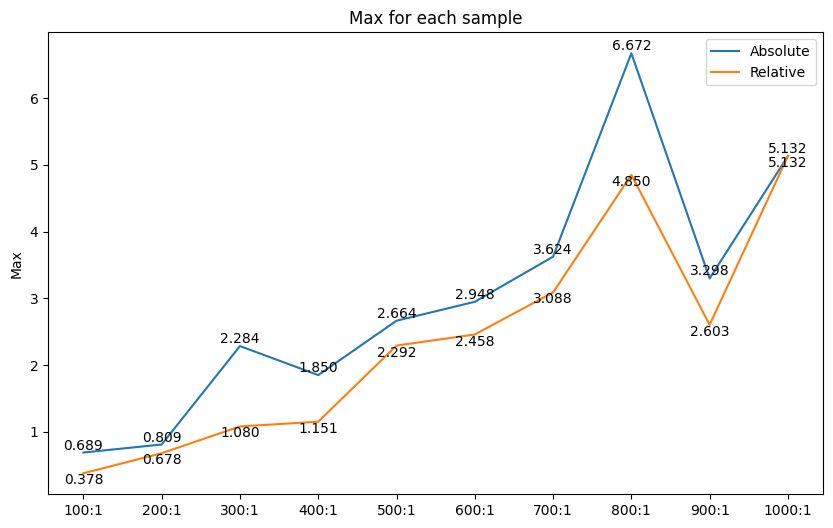

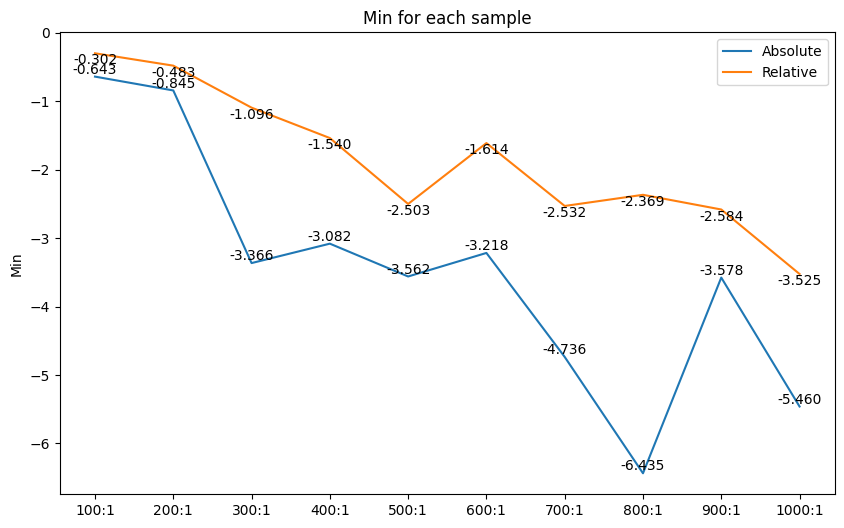

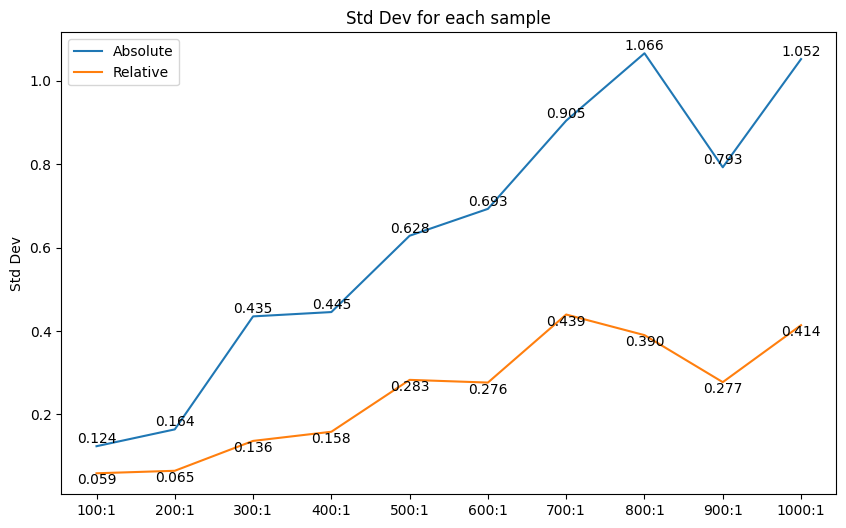

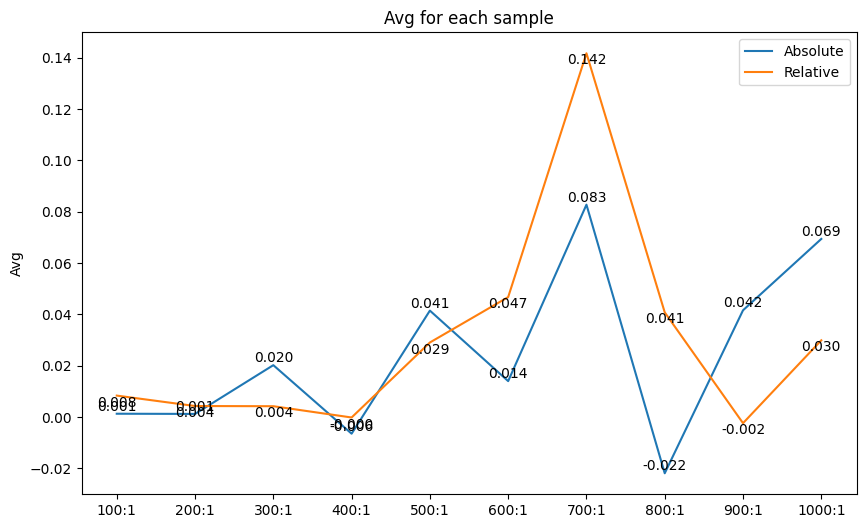

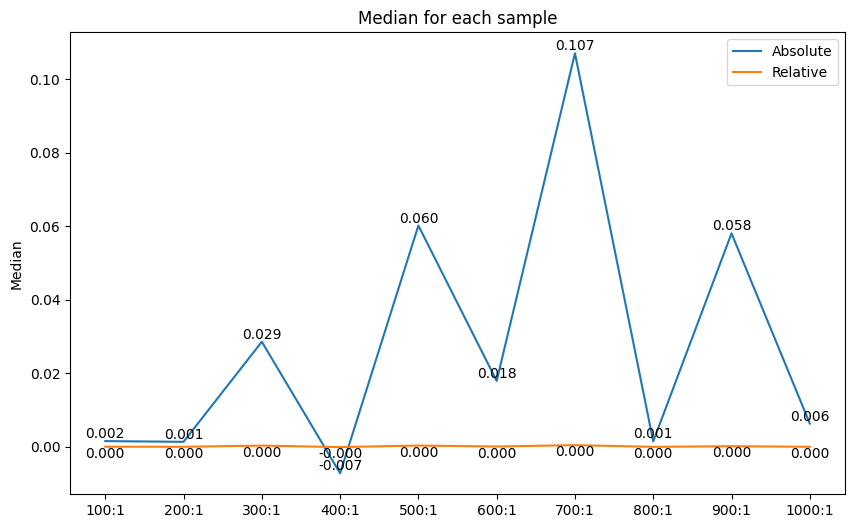

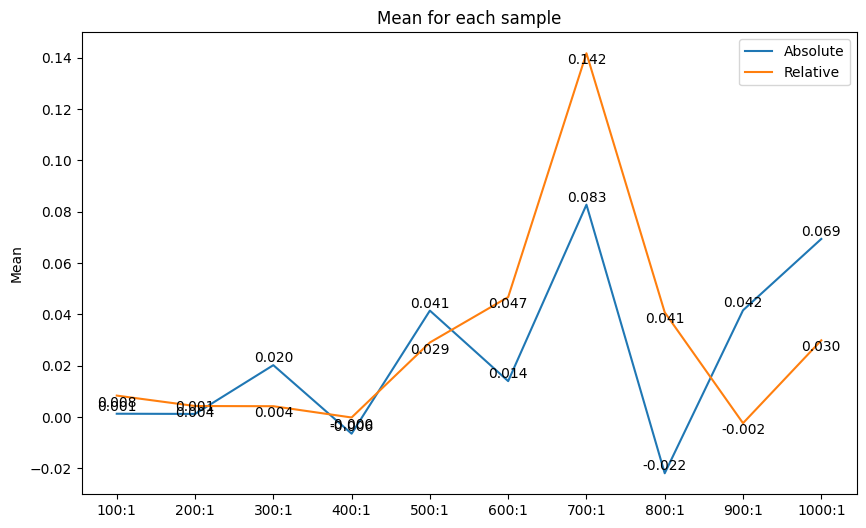

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# 计算统计值
def calculate_stats(data_list):
    stats = []
    for data in data_list:
        max_val = np.max(data)
        min_val = np.min(data)
        std_dev = np.std(data)
        avg = np.mean(data)
        median = np.median(data)
        mean = np.mean(data)
        stats.append([max_val, min_val, std_dev, avg, median, mean])
    return np.array(stats)

# 计算绝对误差和相对误差的统计值
stats_absolute = calculate_stats(absolute_list)
stats_relative = calculate_stats(relative_list)

# 定义统计值的标签
labels = ['Max', 'Min', 'Std Dev', 'Avg', 'Median', 'Mean']

# 定义x轴的标签
x = ['100:1', '200:1', '300:1', '400:1', '500:1', '600:1', '700:1', '800:1', '900:1', '1000:1']

# 对于每一个统计值，绘制一条折线图
for i in range(len(labels)):
    plt.figure(figsize=(10, 6))
    plt.plot(stats_absolute[:, i], label='Absolute')
    plt.plot(stats_relative[:, i], label='Relative')
    
    # 在每个数据点上添加标签
    for j in range(len(x)):
        plt.text(j, stats_absolute[j, i], f'{stats_absolute[j, i]:.3f}', ha='center', va='bottom')
        plt.text(j, stats_relative[j, i], f'{stats_relative[j, i]:.3f}', ha='center', va='top')
    
    plt.xticks(range(len(x)), x)  # 设置x轴的标签
    plt.ylabel(labels[i])
    plt.title(f'{labels[i]} for each sample')
    plt.legend()
    plt.show()

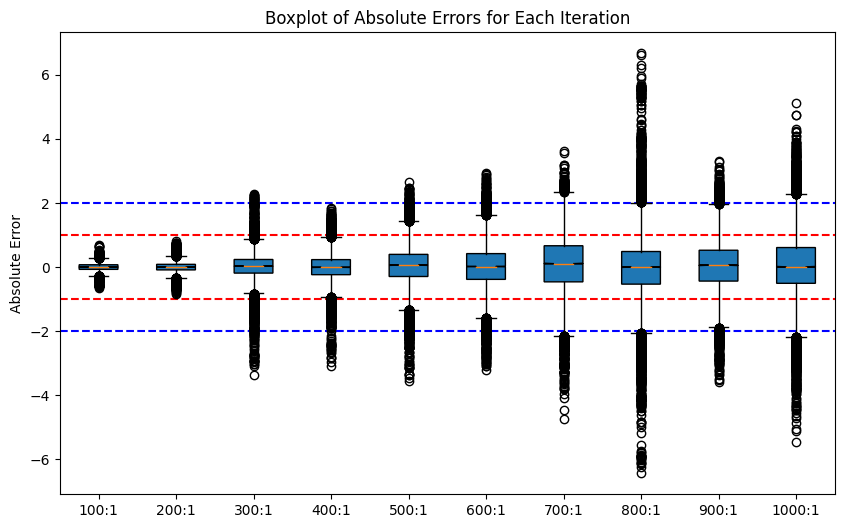

In [12]:
import matplotlib.pyplot as plt
# 假设你的标签列表是这样的
x = ['100:1', '200:1', '300:1', '400:1', '500:1', '600:1', '700:1', '800:1', '900:1', '1000:1']
# 创建一个新的图形
plt.figure(figsize=(10, 6))
# 在-1, 1, 2, -2处添加水平线
plt.axhline(y=-1, color='r', linestyle='--')
plt.axhline(y=1, color='r', linestyle='--')
plt.axhline(y=2, color='b', linestyle='--')
plt.axhline(y=-2, color='b', linestyle='--')
# 创建箱线图
# 注意：你需要将你的数据转换为列表并传入到boxplot函数中
plt.boxplot(absolute_list, vert=True, notch=True, patch_artist=True)

# 设置x轴的标签为你的x列表
plt.xticks(range(1, len(x) + 1), x)

# 设置标题和标签
plt.title('Boxplot of Absolute Errors for Each Iteration')
plt.ylabel('Absolute Error')

# 显示图形
plt.show()

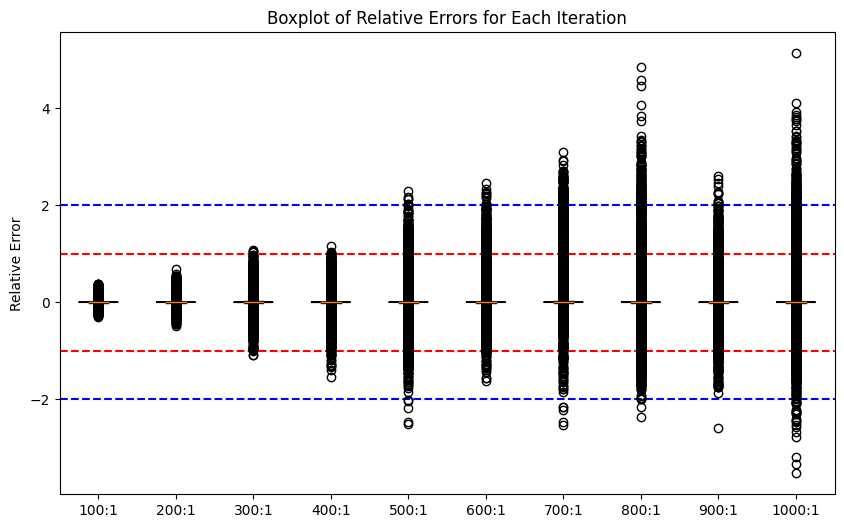

In [13]:
import matplotlib.pyplot as plt
# 假设你的标签列表是这样的
x = ['100:1', '200:1', '300:1', '400:1', '500:1', '600:1', '700:1', '800:1', '900:1', '1000:1']
# 创建一个新的图形
plt.figure(figsize=(10, 6))
# 在-1, 1, 2, -2处添加水平线
plt.axhline(y=-1, color='r', linestyle='--')
plt.axhline(y=1, color='r', linestyle='--')
plt.axhline(y=2, color='b', linestyle='--')
plt.axhline(y=-2, color='b', linestyle='--')
# 创建箱线图
# 注意：你需要将你的数据转换为列表并传入到boxplot函数中
plt.boxplot(relative_list, vert=True, notch=True, patch_artist=True)
#plt.ylim(-0.25, 0.25)

# 设置x轴的标签为你的x列表
plt.xticks(range(1, len(x) + 1), x)

# 设置标题和标签
plt.title('Boxplot of Relative Errors for Each Iteration')
plt.ylabel('Relative Error')

# 显示图形
plt.show()

In [14]:
import numpy as np
import itertools

# 找到 '500:1' 在 x 中的索引
index = x.index('500:1')

# 获取相应的数据
data = absolute_list[index]

# 计算四分位数和IQR
q1 = np.percentile(data, 25)
q3 = np.percentile(data, 75)
iqr = q3 - q1

# 计算上下界
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr


# 找到异常值及其索引
outliers = [(i, val) for i, val in enumerate(data) if val < lower_bound or val > upper_bound]
outlier_indices = [outlier[0] for outlier in outliers]
outlier_val = [outlier[1] for outlier in outliers]
areas = [0,2,160,300,480]
centers = [20,30,40,60,70]
area_combinations = list(itertools.product(areas, repeat=len(centers)))


In [15]:
# 初始化一个空的字典来存储分组的索引
grouped_indices = {}

# 对每个异常值的索引进行模除5并分组
for index in outlier_indices:
    remainder = index // 5
    if remainder not in grouped_indices:
        grouped_indices[remainder] = [index]
    else:
        grouped_indices[remainder].append(index)

# 输出分组的索引
for remainder, indices in grouped_indices.items():
    #print(f'Remainder: {remainder}, Indices: {indices}')

    # 根据模除的结果在area_combinations中找到对应的组合
    area_combination = area_combinations[remainder]
    #print(f'Corresponding area combination: {area_combination}')

    for index in indices:
        corresponding_number = area_combination[index % 5]
        print(f'Index: {index}, Corresponding number: {corresponding_number}')
    

Index: 112, Corresponding number: 0
Index: 536, Corresponding number: 0
Index: 555, Corresponding number: 0
Index: 560, Corresponding number: 0
Index: 1180, Corresponding number: 0
Index: 1185, Corresponding number: 0
Index: 1570, Corresponding number: 0
Index: 1695, Corresponding number: 0
Index: 1753, Corresponding number: 0
Index: 1755, Corresponding number: 0
Index: 1760, Corresponding number: 0
Index: 1778, Corresponding number: 2
Index: 1783, Corresponding number: 2
Index: 1820, Corresponding number: 0
Index: 1845, Corresponding number: 0
Index: 1850, Corresponding number: 0
Index: 1860, Corresponding number: 0
Index: 1865, Corresponding number: 0
Index: 1986, Corresponding number: 300
Index: 1991, Corresponding number: 300
Index: 2195, Corresponding number: 0
Index: 2378, Corresponding number: 0
Index: 2383, Corresponding number: 0
Index: 2403, Corresponding number: 2
Index: 2408, Corresponding number: 2
Index: 2442, Corresponding number: 480
Index: 2447, Corresponding number: 4

In [16]:
import pandas as pd

# 初始化一个空的 DataFrame
df = pd.DataFrame(columns=['Combination', 'Corresponding Number'])

# 获取异常值
outlier_val = [outlier[1] for outlier in outliers]

# 遍历每个组
for remainder, indices in grouped_indices.items():
    # 根据模除的结果找到对应的组合
    area_combination = area_combinations[remainder]

    if len(indices) == 1:
        for i, index in enumerate(indices):
            # 找到对应的数字
            corresponding_number = area_combination[index % 5]

            # 创建一个新的组合字符串，只在索引对应的数字后面添加括号和异常值
            area_combination_str = "(" + ", ".join([f"{num} ({outlier_val[i]})" if idx == index % 5 else str(num) for idx, num in enumerate(area_combination)]) + ")"

            # 创建一个新的 DataFrame 并将其添加到原始 DataFrame 中
            new_df = pd.DataFrame({
                'Combination': [area_combination_str],
                'Corresponding Number': [corresponding_number],
            })
            df = pd.concat([df, new_df], ignore_index=True)
    else:
        # 对多个值的情况进行处理
        area_combination_str = [str(num) for num in area_combination]
        for i, index in enumerate(indices):
            num_idx = index % 5
            if '(' in area_combination_str[num_idx]:
                # 如果已经有异常值，追加
                area_combination_str[num_idx] = area_combination_str[num_idx].replace(')', f", {outlier_val[i]})")
            else:
                area_combination_str[num_idx] = f"{area_combination[num_idx]} ({outlier_val[i]})"
        
        area_combination_str = "(" + ", ".join(area_combination_str) + ")"
        corresponding_numbers = [area_combination[index % 5] for index in indices]
        
        new_df = pd.DataFrame({
            'Combination': [area_combination_str],
            'Corresponding Number': [corresponding_numbers],
        })
        df = pd.concat([df, new_df], ignore_index=True)

# 打印 DataFrame
print(df)

# 将 DataFrame 保存到 CSV 文件
df.to_csv('outliers.csv', index=False)

                                           Combination Corresponding Number
0             (0, 0, 0 (1.4886937141418457), 480, 160)                    0
1             (0, 0 (1.4886937141418457), 480, 2, 160)                    0
2             (0 (1.4886937141418457), 0, 480, 160, 2)                    0
3           (0 (1.4886937141418457), 0, 480, 160, 160)                    0
4             (0 (1.4886937141418457), 2, 480, 160, 2)                    0
..                                                 ...                  ...
529       (480, 480 (1.4886937141418457), 480, 480, 0)                  480
530       (480, 480 (1.4886937141418457), 480, 480, 2)                  480
531     (480, 480 (1.4886937141418457), 480, 480, 160)                  480
532     (480, 480 (1.4886937141418457), 480, 480, 300)                  480
533  (480, 480 (1.4886937141418457), 480, 480 (-1.3...           [480, 480]

[534 rows x 2 columns]


In [17]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train_classification shape: {y_train_classification.shape}')
print(f'y_train_regression shape: {y_train_regression.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val_classification shape: {y_val_classification.shape}')
print(f'y_val_regression shape: {y_val_regression.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test_classification shape: {y_test_classification.shape}')
print(f'y_test_regression shape: {y_test_regression.shape}')

X_train shape: (26214, 100)
y_train_classification shape: (26214, 100)
y_train_regression shape: (26214, 5)
X_val shape: (6554, 100)
y_val_classification shape: (6554, 100)
y_val_regression shape: (6554, 5)
X_test shape: (3125, 100)
y_test_classification shape: (3125, 100)
y_test_regression shape: (3125, 5)


In [18]:
import numpy as np
import itertools
import pandas as pd


def analyze_sample(sample_index, absolute_list, x, areas, centers):
    # 找到样本在 x 中的索引
    sample_label = x[sample_index - 1]
    print(f'Analyzing sample: {sample_label}')

    # 获取相应的数据
    data = absolute_list[sample_index - 1]

    # 计算四分位数和IQR
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1

    # 计算上下界
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    print(f'Lower Bound: {lower_bound}, Upper Bound: {upper_bound}')

    # 找到异常值及其索引
    outliers = [(i, val) for i, val in enumerate(data) if val < lower_bound or val > upper_bound]
    outlier_indices = [outlier[0] for outlier in outliers]
    outlier_vals = [outlier[1] for outlier in outliers]

    # 创建一个字典来确保索引和异常值匹配
    outlier_dict = dict(zip(outlier_indices, outlier_vals))

    # 生成所有可能的组合
    area_combinations = list(itertools.product(areas[sample_index - 1], repeat=len(centers)))

    #计算所有组合中0的个数
    zero_count = 0
    for area_combination in area_combinations:
        zero_count += area_combination.count(0)

    # 初始化一个空的字典来存储分组的索引
    grouped_indices = {}

    # 对每个异常值的索引进行模除5并分组
    for index in outlier_indices:
        remainder = index // 5
        if remainder not in grouped_indices:
            grouped_indices[remainder] = [index]
        else:
            grouped_indices[remainder].append(index)

    # 初始化一个空的 DataFrame
    df = pd.DataFrame(columns=['Combination', 'Corresponding Number'])

    # 初始化 zero_count 总和计数器
    total_zero_outlier_count = 0

    # 遍历每个组
    for remainder, indices in grouped_indices.items():
        # 根据模除的结果找到对应的组合
        area_combination = area_combinations[remainder]
        zero_outlier_count = 0  # 初始化当前组的0的异常值计数器

        if len(indices) == 1:
            for index in indices:
                # 找到对应的数字
                corresponding_number = area_combination[index % 5]

                # 通过 outlier_dict 字典获得异常值
                val = outlier_dict[index]

                # 检查是否是0且为outlier
                if corresponding_number == 0:
                    zero_outlier_count += 1

                # 创建一个新的组合字符串，只在索引对应的数字后面添加括号和异常值
                area_combination_str = "(" + ", ".join([f"{num} ({val})" if idx == index % 5 else str(num) for idx, num in enumerate(area_combination)]) + ")"

                # 创建一个新的 DataFrame 并将其添加到原始 DataFrame 中
                new_df = pd.DataFrame({
                    'Combination': [area_combination_str],
                    'Corresponding Number': [corresponding_number]
                })
                df = pd.concat([df, new_df], ignore_index=True)
        else:
            # 对多个值的情况进行处理
            area_combination_str = [str(num) for num in area_combination]
            for index in indices:
                num_idx = index % 5
                val = outlier_dict[index]
                if '(' in area_combination_str[num_idx]:
                    # 如果已经有异常值，追加
                    area_combination_str[num_idx] = area_combination_str[num_idx].replace(')', f", {val})")
                else:
                    area_combination_str[num_idx] = f"{area_combination[num_idx]} ({val})"
                
                # 检查是否是0且为outlier
                if area_combination[num_idx] == 0:
                    zero_outlier_count += 1
            
            area_combination_str = "(" + ", ".join(area_combination_str) + ")"
            corresponding_numbers = [area_combination[index % 5] for index in indices]
            
            new_df = pd.DataFrame({
                'Combination': [area_combination_str],
                'Corresponding Number': [corresponding_numbers]
            })
            df = pd.concat([df, new_df], ignore_index=True)

        # 累加当前组的 zero_outlier_count 到 total_zero_outlier_count
        total_zero_outlier_count += zero_outlier_count

    # 打印 DataFrame
    print(df)
    
    # 打印 zero_outlier_count 总和
    print(f"Total count of 0 as outliers: {total_zero_outlier_count}")
    print(f"Total count of 0 in all combinations: {zero_count}")
    
    # 计算0作为outlier的百分比
    if zero_count > 0:
        zero_outlier_percentage = (total_zero_outlier_count / zero_count) * 100
        print(f"Percentage of 0 as outliers: {zero_outlier_percentage:.2f}%")
    else:
        print("No 0 values found in the data.")
    
    # 将 DataFrame 保存到 CSV 文件
    df.to_csv(f'outliers_{sample_label}.csv', index=False)
# 示例调用

x = ['100:1', '200:1', '300:1', '400:1', '500:1', '600:1', '700:1', '800:1', '900:1', '1000:1']
Training_areas =[[0,1,2,4,20, 50, 80, 100], [0,1,4,6,40, 100, 160, 200], [0,1,6,8,60,150,240,300], [0, 1,8,10,80, 200, 320, 400], 
                 [0, 1,10,12,100, 250, 400, 500], [0, 1,12,14,120, 300, 480, 600], [0,1,14,16,140, 350, 560, 700], [0,1,16,18,160, 400, 640, 800],
                 [0,1,18,20,180, 450, 720, 900], [0,1,20,22,200, 500, 800, 1000]]
#Training_areas = [[0,1,20,50,80,100], [0,1,40,100,160,200], [0,1,60,150,240,300], [0,1,80,200,320,400], [0,1,100,250,400,500], [0,1,120,300,480,600], [0,1,140,350,560,700], [0,1,160,400,640,800], [0,1,180,450,720,900], [0,1,200,500,800,1000]]
#Testing_areas = [[0,2,30,60,100] ,[0,2,70,120,175],[0,2,80,170,280],[0,2,100,250,370],[0,2,160,300,480],[0,2,240,350,560],[0,2,255,400,600],[0,2,290,450,720],[0,2,340,500,800],[0,2,370,550,880]]
Testing_areas = [
    [0, 2, 25, 55, 105],
    [0, 3, 45, 110, 180],
    [0, 4, 75, 160, 275],
    [0, 5, 95, 260, 385],
    [0, 6, 150, 310, 490],
    [0, 7, 230, 360, 590],
    [0, 8, 250, 410, 610],
    [0, 9, 280, 460, 730],
    [0, 10, 330, 510, 810],
    [0, 12, 360, 550, 900]
]
centers = [20,30,40,60,70]

for i in range(1,11):
    analyze_sample(i, absolute_list, x, Testing_areas, centers)  # 查看第n个样本

Analyzing sample: 100:1
Lower Bound: -0.2866249084472656, Upper Bound: 0.2878684997558594
                                           Combination Corresponding Number
0               (0, 0, 0, 105, 0 (0.3107553720474243))                    0
1              (0, 0, 0, 105, 105 (0.316009521484375))                  105
2                 (0, 0, 105 (0.311767578125), 25, 55)                  105
3              (0, 2, 0, 105, 0 (0.29807180166244507))                    0
4            (0, 55, 25 (0.3012866973876953), 105, 25)                   25
..                                                 ...                  ...
357  (105 (0.33823394775390625), 105, 105 (0.416542...           [105, 105]
358  (105 (0.3196258544921875), 105, 105 (0.3484497...           [105, 105]
359  (105 (0.33403778076171875), 105 (-0.2926177978...      [105, 105, 105]
360  (105 (0.31340789794921875), 105 (-0.3146057128...      [105, 105, 105]
361  (105 (0.30121612548828125), 105, 105 (0.357238...           [105, 105